In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [5]:
from fastai import *
from fastai.vision import *

In [6]:
size = 224
bs = 4

In [7]:
dataDir = "/home/tako/devtools/furry-geras/coco"
dataType = "val2017"
annFile = "{}/instances_{}.json".format(dataDir, dataType)

images, lbl_bbox = get_annotations(annFile)
img2bbox = dict(zip(images, lbl_bbox))


In [8]:
get_y_func = lambda o:img2bbox[o.name] if o.name in img2bbox else [None,None]
print(get_y_func(Path("coco/val2017/000000140286.jpg")))
print(get_y_func(Path("coco/val2017/000000200152.jpg")))

[[[249.08, 96.54, 445.64, 269.15000000000003], [226.35, 417.67, 328.07, 517.57], [265.36, 254.83, 337.95000000000005, 282.93]], ['horse', 'person', 'person']]
[None, None]


In [9]:
def get_y_func(o):
    result = [[],[]]
    if o.name in img2bbox:
        lbl_bbox = img2bbox[o.name] 
    else:
        return [None,None]
    for i, obj in enumerate(lbl_bbox[1]):
        if obj =='person':
            result[1].append(obj)
            result[0].append(lbl_bbox[0][i])
    return result

print(get_y_func(Path("coco/val2017/000000140286.jpg")))
print(get_y_func(Path("coco/val2017/000000200152.jpg")))

[[[226.35, 417.67, 328.07, 517.57], [265.36, 254.83, 337.95000000000005, 282.93]], ['person', 'person']]
[None, None]


In [10]:
def remove_non_human(f):
    classes = get_y_func(f)[1]
    if classes is None:
        return False
    return 'person' in classes

print(remove_non_human(Path("coco/val2017/000000140286.jpg")))
print(remove_non_human(Path("coco/val2017/000000200152.jpg")))

True
False


In [11]:
src = (ObjectItemList.from_folder('coco/val2017')
        .filter_by_func(remove_non_human)
        #Where are the images?
        .random_split_by_pct()                          
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_func)
        #How to find the labels? -> use get_y_func
       )
src

LabelLists;

Train: LabelList
y: ObjectCategoryList (2155 items)
[ImageBBox (393, 640), ImageBBox (427, 640), ImageBBox (426, 640), ImageBBox (479, 640), ImageBBox (427, 640)]...
Path: coco/val2017
x: ObjectItemList (2155 items)
[Image (3, 393, 640), Image (3, 427, 640), Image (3, 426, 640), Image (3, 479, 640), Image (3, 427, 640)]...
Path: coco/val2017;

Valid: LabelList
y: ObjectCategoryList (538 items)
[ImageBBox (446, 640), ImageBBox (500, 375), ImageBBox (640, 463), ImageBBox (383, 500), ImageBBox (332, 500)]...
Path: coco/val2017
x: ObjectItemList (538 items)
[Image (3, 446, 640), Image (3, 500, 375), Image (3, 640, 463), Image (3, 383, 500), Image (3, 332, 500)]...
Path: coco/val2017;

Test: None

Note the size differences. In other areas this does not seem to be a problem. However here it seems it does.

In [17]:
tfms = get_transforms() # or tfms=None if none are needed
data = src.transform(tfms=tfms, tfm_y=True, size=128 )
data

LabelLists;

Train: LabelList
y: ObjectCategoryList (2155 items)
[ImageBBox (393, 640), ImageBBox (427, 640), ImageBBox (426, 640), ImageBBox (479, 640), ImageBBox (427, 640)]...
Path: coco/val2017
x: ObjectItemList (2155 items)
[Image (3, 393, 640), Image (3, 427, 640), Image (3, 426, 640), Image (3, 479, 640), Image (3, 427, 640)]...
Path: coco/val2017;

Valid: LabelList
y: ObjectCategoryList (538 items)
[ImageBBox (446, 640), ImageBBox (500, 375), ImageBBox (640, 463), ImageBBox (383, 500), ImageBBox (332, 500)]...
Path: coco/val2017
x: ObjectItemList (538 items)
[Image (3, 446, 640), Image (3, 500, 375), Image (3, 640, 463), Image (3, 383, 500), Image (3, 332, 500)]...
Path: coco/val2017;

Test: None

In [18]:
data = data.databunch(bs=bs, collate_fn=bb_pad_collate,num_workers=4).normalize()

As I understand this error it means that the image size do not match however I did specify the desired size.

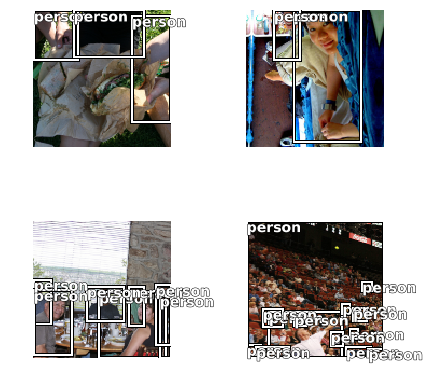

In [24]:
data.show_batch(rows=2, ds_type=DatasetType.Train, figsize=(6,6))

In [27]:
learn = create_cnn(data, models.resnet18)
learn.fit(1)

epoch,train_loss,valid_loss


TypeError: __call__() takes 3 positional arguments but 4 were given